# Predicting the spread of COVID-19 in Italy
In this notebook I will try to replicate and "*analyze*" the results presented in this [article](https://statisticallearningtheory.wordpress.com/2020/03/02/previsione-della-crescita-esponenziale-dei-covid19-positivi-in-italia-lombardia-veneto-ed-e-romagna/) about the spread of COVID-19 in Italy, using concepts from [regression analysis](https://en.wikipedia.org/wiki/Regression_analysis). 

**Premise:** I have no knowledge in the medical field and this notebook has to be intended as an amateur work.

In the article, the growth of the infected population is modeled under the simplified hypothesis that it follows an *exponential growth*. The model class in which we'll seek for a good approximation of the function describing the growth is then:

$$\text{model class: }\{y(t)=ce^{rt}\text{, parameter} =(c,r)\}$$

where:
- $y(t)$ is the number of infected people at time $t$ (in the article $y=N_{positivi}$);
- $t$ indicates the number of days since a reference date (e.g. Feb 27, 2020);
- unknown parameters $c \in \mathbb{R}^+$ and $r \in \mathbb{R}^+$.

In the *measurement model*, we are used to write $u_i$ and $y_i$ for the *i*-th input and measure respectively, but since, in this case, the input represents the days that have passed since a certain date, I hope no one gets offended if I write the measurement model as:

$$y_t = ce^{rt} + \varepsilon$$

where $\varepsilon_i$ is a random *error term* independent from $t$.

This is a **non-linear model** because it can't be expressed as a linear combination of its parameters. In general, it is quite difficult to manage non-linear functions in an optimization context, since the function that we want to optimize (the gradient of a certain cost function) can have many local minima and gradient descent techniques are not guaranteed to converge to the global minimum.

Anyway, if we assume that the error is positive and multiplicative, we can take the natural logarithm of both sides of the equation and obtain:

$$\ln(y_t) = \ln(c) + rt + \ln(\varepsilon)$$

that is a **linear model** in the parameters $(\ln(c), r)$.

Let's try to implement linear regression in Python using data taken from the Wikipedia page: [2020 coronavirus outbreak in Italy](https://en.wikipedia.org/wiki/2020_coronavirus_outbreak_in_Italy#Statistics).


In [28]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

y = [650, 888, 1128, 1694, 2036, 2502, 3089, 3858] # total cases from Feb 27, 2020
lny = np.log(y)
n = len(y)
t = np.arange(n) # t = [0, 1, ..., n-1]

X = np.array([np.ones(n), t]).T # construct matrix of regressors

# approach 1: solving the normal equations: params = (X'X)^-1 X' lny
(lnc, r) = np.dot(np.linalg.inv(X.T @ X) @ X.T, lny)

# approach 2: with the Moore-Penrose pseudoinverse
#(lnc, r) = np.dot(np.linalg.pinv(X), lny)

# approach 3: solving a rectangular linear system in the sense of least squares
#(lnc, r) = np.linalg.lstsq(X, lny, rcond=None)[0]

# approach 4: linear regression with batch gradient descent
#(explained later in the notebook)

c = np.exp(lnc)
print('parameter c is expected to be {:.2f}'.format(c))
print('parameter r is expected to be {:.4f}'.format(r))

parameter c is expected to be 697.06
parameter r is expected to be 0.2533


## Visualize the results

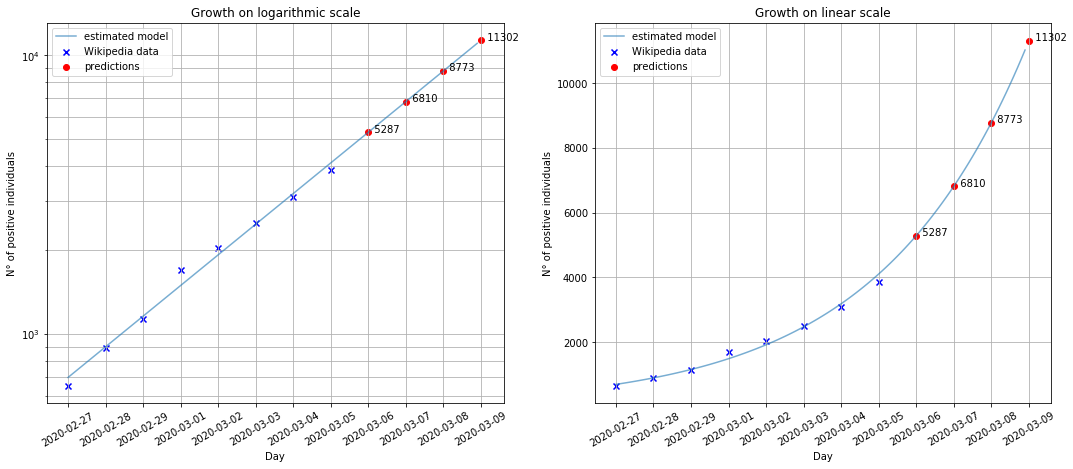

In [45]:
# sample data for plotting purposes
t_start = np.datetime64('2020-02-27') # first day
days = 11 # days to consider since t_start
dates = np.arange(t_start, t_start + days + 1) # list of days from t_start to (t_start + days)
xx = np.arange(0, days, 0.1)
yy = c * np.exp(r*xx)

# predictions for next days
t_pred = np.arange(t[-1] + 1, days + 1)
y_pred = c * np.exp(r*t_pred)

# plot: semilogarithmic scale
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,7))
ax1.scatter(t, y, marker='x', color='b', label='Wikipedia data')
ax1.scatter(t_pred, y_pred, marker='o', color='r', label='predictions')
ax1.semilogy(xx, yy, alpha=0.6, label='estimated model')
ax1.grid(True, which='both')
ax1.set_xticks(range(days+1))
ax1.set_xticklabels(dates)
ax1.xaxis.set_tick_params(rotation=30, labelsize=10)
ax1.set_title('Growth on logarithmic scale')
ax1.set_xlabel('Day')
ax1.set_ylabel('N° of positive individuals')
ax1.legend()
[ax1.annotate('  {:.0f}'.format(y), (t, y)) for (t,y) in zip(t_pred, y_pred)]

# plot: linear scale
ax2.scatter(t, y, marker='x', color='b', label='Wikipedia data')
ax2.scatter(t_pred, y_pred, marker='o', color='r', label='predictions')
ax2.plot(xx, yy, alpha=0.6, label='estimated model')
ax2.grid(True)
ax2.set_xticks(range(days+1))
ax2.set_xticklabels(dates)
ax2.xaxis.set_tick_params(rotation=30, labelsize=10)
ax2.set_xlabel('Day')
ax2.set_ylabel('N° of positive individuals')
ax2.set_title('Growth on linear scale')
ax2.legend()
[ax2.annotate('  {:.0f}'.format(y), (t, y)) for (t,y) in zip(t_pred, y_pred)]
plt.show()

## Considerations (WORK IN PROGRESS)
An exponential model (a **Malthusian growth model**) is based on the idea that the function describing the growth of the population is proportional to the speed to which it grows. Indeed, in continuous time, the exponential model comes as a solution of the Cauchy problem:

$$
\begin{cases}
\frac{\text{d}y}{\text{d}t} = ry(t) \\
y(t_0)=c
\end{cases}
$$

where:
- $r =$ population growth rate
- $c_0 =$ initial population size

That problem admits the solution $y(t)=ce^{rt}$.

Modelling the spread of the virus as an exponential curve is too simplistic because the fundamental **assumption** of the Malthusian growth is that the **resources are unlimited**.

In nature, populations may grow exponentially for some period, but they will ultimately be limited by resource availability. For these reasons, we should adopt a more reasonable model, namely the **Verhulst logistic model**.
In logistic growth, a population's per capita growth rate gets smaller and smaller as population size approaches a maximum imposed by limited resources in the environment, known as the carrying capacity $K$.

$$\frac{\text{d}y}{\text{d}t} = ry\left(1-\frac{y}{K}\right)$$

a solution to this equation is:

$$y(t)=\frac{K}{1+cKe^{-rt}}$$

where $c = \frac{1}{y(0)} - \frac{1}{K}$ depends on the initial condition $y(0)$.

A logistic function has the following shape:

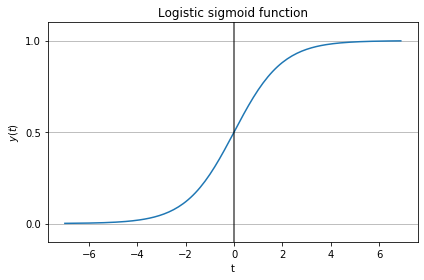

In [49]:
def sigmoid(t):
    return 1.0 / (1.0 + np.exp(-t))

# plotting a logistic sigmoid function
t = np.arange(-7, 7, 0.1)
y_t = sigmoid(t)
plt.plot(t, y_t)
plt.axvline(x=0.0, color='k', alpha=0.7)
plt.ylim(-0.1, 1.1)
plt.yticks([0.0, 0.5, 1.0])
plt.title('Logistic sigmoid function')
plt.xlabel('t')
plt.ylabel(r'$y(t)$')
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

## EXTRA: Implementing Linear Regression with gradient descent from scratch

After a brief, non-rigorous explanation of how [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) works, you will find a simple implementation of linear regression using standard *batch gradient descent*.

The simplest implementation of gradient descent consists into repeating, until a termination condition is met, the following update rule for each parameter:

$$\theta_j := \theta_j - \eta \frac{\partial}{\partial \theta_j}{J(\theta)}$$


where:
- $\theta_j$ is the *j*-th parameter (or weight)
- $\eta$ is the step (or learning rate)
- $J(\theta)$ is a cost function to be minimized

In linear regression, the cost function is usually the sum of squared errors (residuals):

$$J(\theta)=\frac{1}{2}\sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)}^2$$

where the estimate $\hat{y}_i$ is given by the scalar product between the *i*-th regressor (in our case $\varphi_i= [1, x_i]^T$) and the parameter vector (in our case $\theta=[\theta_1, \theta_2]^T=[c,r]^T$).

$$\hat{y}_i=\varphi_i^T \theta$$

By computing its partial derivative with respect to $\theta_j$ we obtain:

$$\frac{\partial}{\partial \theta_j}{J(\theta)}=-\sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)}x_i^{(j)}$$

Note: the superscript $(j)$ in $x_i^{(j)}$ indicates the *j*-th element of the *i*-th regressors $\varphi_i$.

Then, at each step of the gradient descent algorithm, each of the coefficients is updated according to the following rule:

$$\theta_j := \theta_j + \eta \sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)}x_i^{(j)}$$

In [50]:
class LinearRegressionGD(object):
  """Simple linear regression using batch gradient descent"""

  def __init__(self, eta=0.01, n_iter=200):
    self.eta = eta
    self.n_iter = n_iter

  def fit(self, X, y):
    """
    X is the matrix containing the regressors (features).
    Its first column must be a column of ones
    """
    self.coef_ = np.zeros(X.shape[1]) # parameters (weights) vector
    self.cost_ = []

    # Gradient descent
    for i in range(self.n_iter):
      output = self.predict(X)
      errors = (y - output)
      self.coef_ += self.eta * X.T.dot(errors)
      cost = (errors**2).sum() / 2.0
      self.cost_.append(cost)
    return self

  def predict(self, X):
    return np.dot(X, self.coef_)

# Approach 4: Solve the exponential growth problem with linear regression + gradient descent
lr = LinearRegressionGD(eta=0.01, n_iter=500)
lr.fit(X, lny) # train the model
(lnc, r) = lr.coef_ # extract estimated coefficients
c = np.exp(lnc)
print('parameter c is expected to be {:.2f}'.format(c))
print('parameter r is expected to be {:.4f}'.format(r))

parameter c is expected to be 697.02
parameter r is expected to be 0.2533
